In [1]:
from pathlib import Path
import pandas as pd
import os
import numpy as np

In [2]:
root_path = str(Path(os.getcwd()).parent)
data_path = root_path + "/data"

In [3]:
df = pd.read_excel(data_path + "/sales_data.xlsx")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    1000 non-null   int64         
 1   Date              1000 non-null   datetime64[ns]
 2   Customer ID       1000 non-null   object        
 3   Gender            1000 non-null   object        
 4   Age               1000 non-null   int64         
 5   Product Category  1000 non-null   object        
 6   Quantity          1000 non-null   int64         
 7   Price per Unit    1000 non-null   int64         
 8   Total Amount      1000 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 70.4+ KB


In [5]:
df.head()

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


In [ ]:
# Renaming Columns
new_column_names = []
for name in df.columns:
    new_column_names.append(name.replace(" ", "_"))    
df.columns = new_column_names

# This list will help map unique products to an ID.
unique_products_list = []
for category in sorted(df["Product_Category"].unique()):
    for price in sorted(df[df["Product_Category"] == category]["Price_per_Unit"].unique()):
        unique_products_list.append((category, price))

for gender in ["Male", "Female"]:
    df[gender] = (df["Gender"] == gender).astype(int)
           
df["Product_ID"] = 0
df_prods_list = []
agg_dict = {
    "Age": "median",
    "Male": "sum",
    "Female": "sum",
    "Quantity": "sum",
    "Total_Amount": "sum"
}
for id, (category, price) in enumerate(unique_products_list):
    df_product = df.loc[(df["Product_Category"] == category) & (df["Price_per_Unit"] == price)].sort_values(by=["Date"])
    df_product = df_product.groupby([pd.Grouper(key="Date", freq="W-Mon")]).agg(agg_dict).reset_index()
    
    df_product["Product_ID"] = id
    df_product["Product_Category"] = category
    df_product["Price_per_Unit"] = price
    df_product = df_product.fillna(0)
    
    df_product["Time_Unitless"] = [i for i in range(len(df_product))]
    df_product["Year"] = df_product["Date"].dt.year
    df_product["Month"] = df_product["Date"].dt.month
    df_product["Week"] = df_product["Date"].dt.isocalendar().week
    df_product.pop("Date")
    
    individual_windows = 4
    
    window_columns = []
    for window in range(4, individual_windows+4):
        df_product[f"Window_Mean_{window}"] = df_product["Total_Amount"].rolling(window, ).mean().bfill().ffill().round(2)
        window_columns.append(f"Window_Mean_{window}")
    
    df_prods_list.append(df_product)
    

In [19]:
df_output = pd.concat(df_prods_list, ignore_index=True)
df_output.to_csv("output.csv", index=False)

In [18]:
df_output

,Age,Male,Female,Quantity,Total_Amount,Product_ID,Product_Category,Price_per_Unit,Time_Unitless,Year,Month,Week,Window_Mean_4,Window_Mean_5,Window_Mean_6,Window_Mean_7
0,19.0,0,1,1,25,0,Beauty,25,0,2023,1,1,81.25,80.0,70.83,78.57
1,19.0,1,0,2,50,0,Beauty,25,1,2023,1,2,81.25,80.0,70.83,78.57
2,34.0,1,2,10,250,0,Beauty,25,2,2023,1,3,81.25,80.0,70.83,78.57
3,0.0,0,0,0,0,0,Beauty,25,3,2023,1,4,81.25,80.0,70.83,78.57
4,23.0,0,1,3,75,0,Beauty,25,4,2023,1,5,93.75,80.0,70.83,78.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,21.0,2,0,6,3000,14,Electronics,500,45,2023,11,47,1625.00,1700.0,1750.00,2142.86
772,0.0,0,0,0,0,14,Electronics,500,46,2023,11,48,1625.00,1300.0,1416.67,1500.00
773,55.0,0,1,3,1500,14,Electronics,500,47,2023,12,49,1125.00,1600.0,1333.33,1428.57
774,50.0,4,1,12,6000,14,Electronics,500,48,2023,12,50,2625.00,2100.0,2333.33,2000.00


# Done

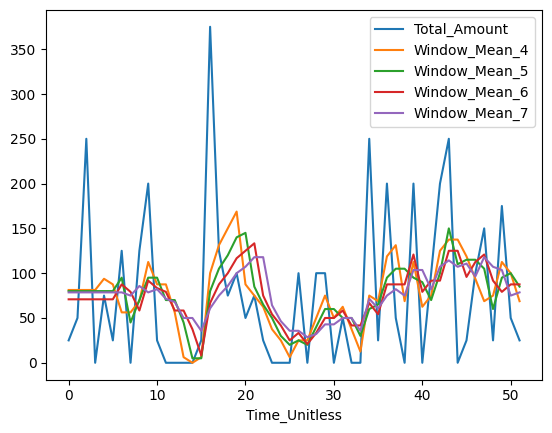

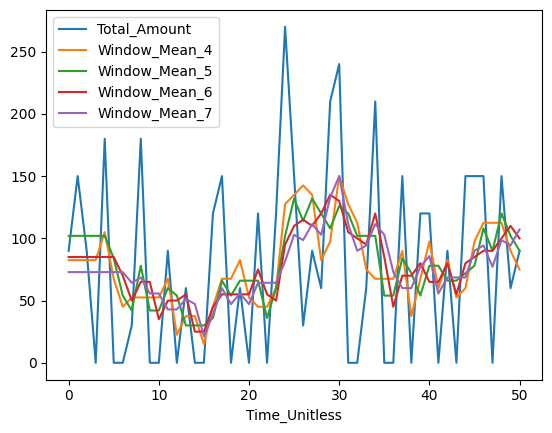

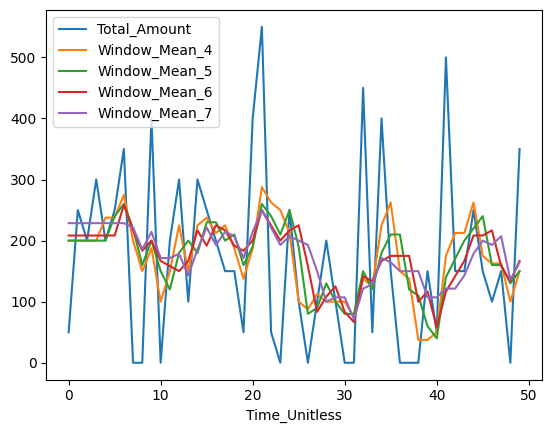

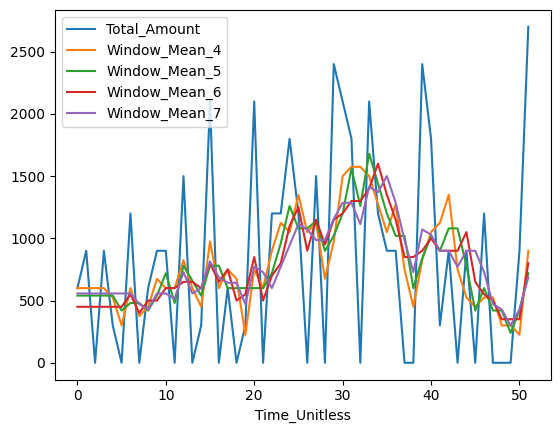

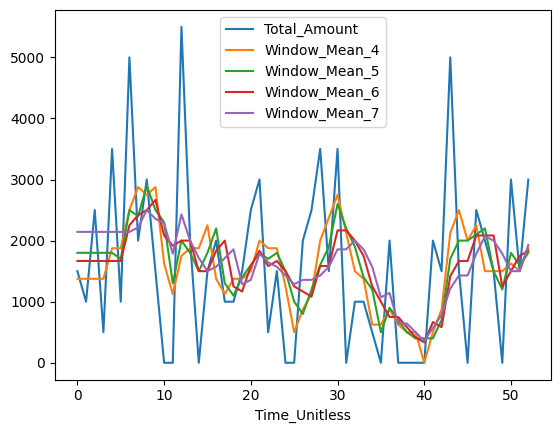

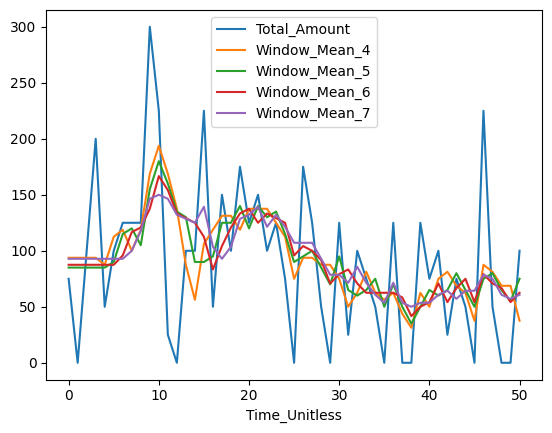

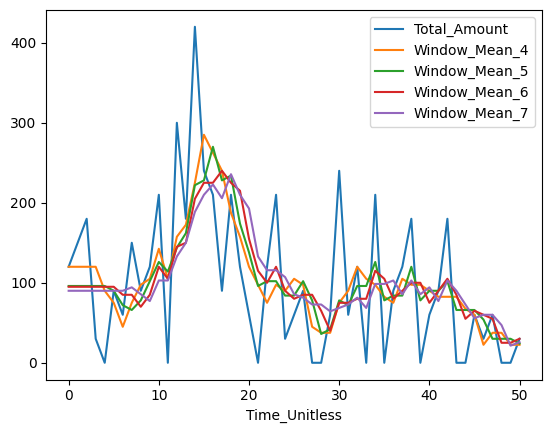

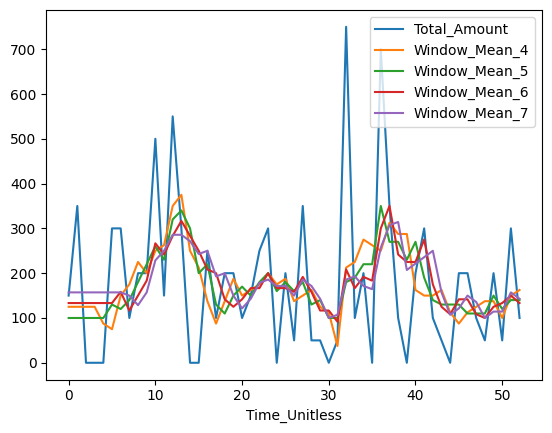

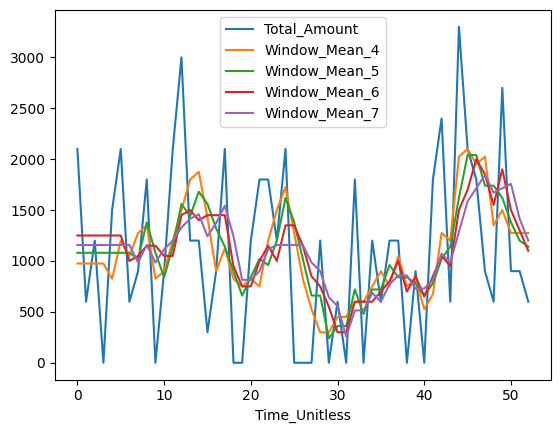

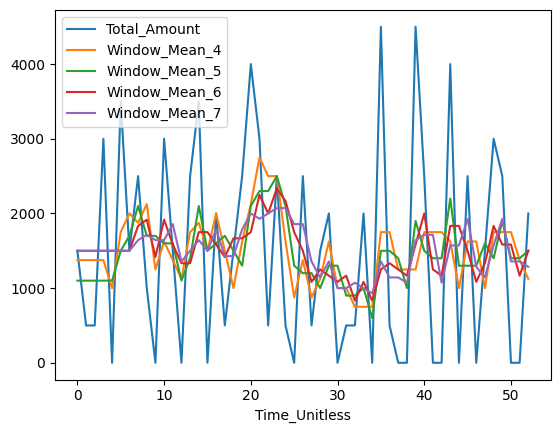

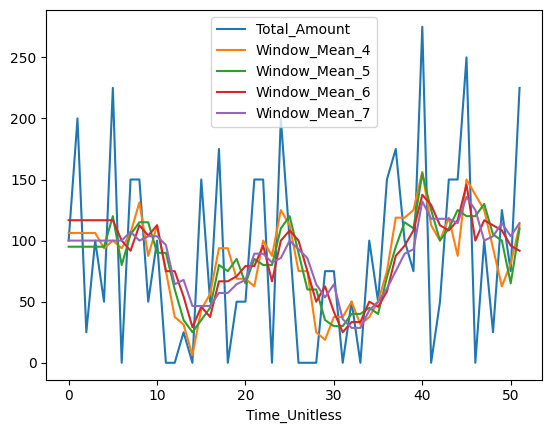

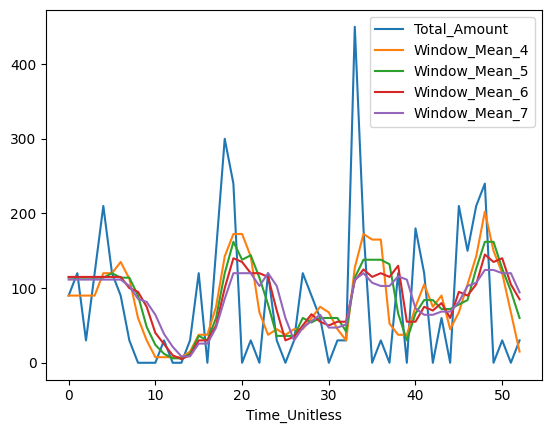

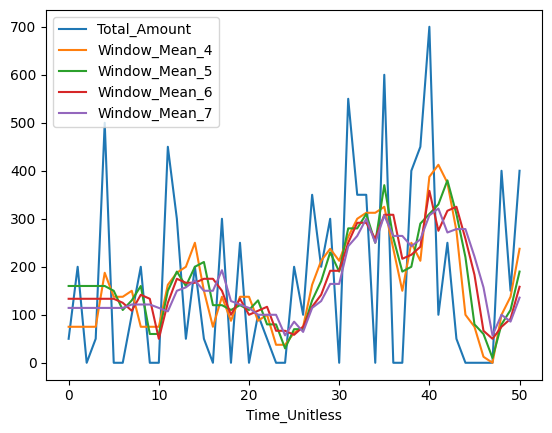

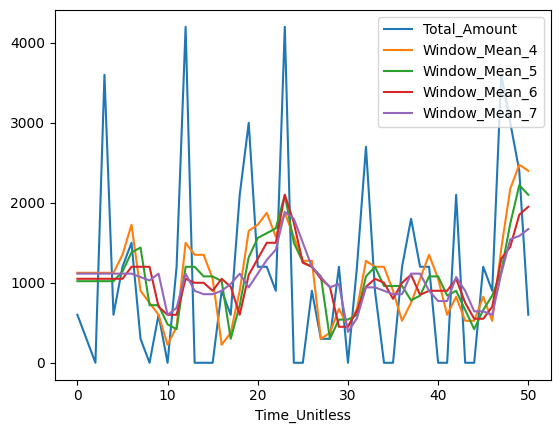

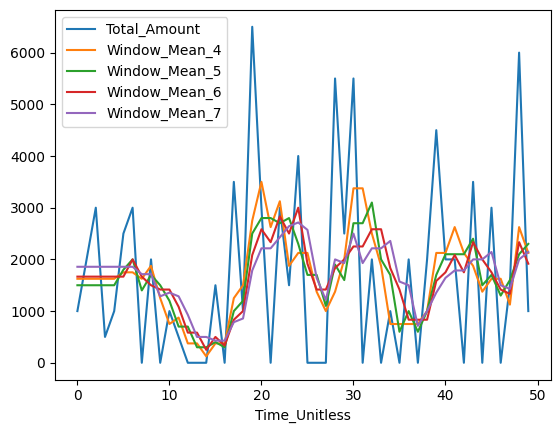

In [14]:
for df_prod in df_prods_list:
    df_prod.plot(x="Time_Unitless", y=["Total_Amount", *window_columns])

In [8]:
df_net = df.drop(["Transaction_ID", "Customer_ID"], axis=1)
for gender in ["Male", "Female"]:
    df_net[gender] = (df_net["Gender"] == gender).astype(int)
df_net

,Date,Gender,Age,Product_Category,Quantity,Price_per_Unit,Total_Amount,Male,Female,Product_ID
0,2023-11-24,Male,34,Beauty,3,50,150,1,0,0
1,2023-02-27,Female,26,Clothing,2,500,1000,0,1,0
2,2023-01-13,Male,50,Electronics,1,30,30,1,0,0
3,2023-05-21,Male,37,Clothing,1,500,500,1,0,0
4,2023-05-06,Male,30,Beauty,2,50,100,1,0,0
...,...,...,...,...,...,...,...,...,...,...
995,2023-05-16,Male,62,Clothing,1,50,50,1,0,0
996,2023-11-17,Male,52,Beauty,3,30,90,1,0,0
997,2023-10-29,Female,23,Beauty,4,25,100,0,1,0
998,2023-12-05,Female,36,Electronics,3,50,150,0,1,0


In [9]:
# -----------------------------
# Adding extra Feature columns  
# -----------------------------
#for category in df_net["Product_Category"].unique():
#    df_net[f"Total_Amount_{category}"] = df_net.loc[df_net["Product_Category"] == category, ["Total_Amount"]] 
#    df_net[f"Quantity_{category}"] = df_net.loc[df_net["Product_Category"] == category, ["Quantity"]] 
#


In [10]:
df_exp = df_net.iloc[:,:]
all_product_ids = df_exp["Product_ID"].unique() 
product_dfs = []

agg_list = {
    #"Product_ID": lambda x: 2,
    "Age": "median",
    "Male": "sum",
    "Female": "sum",
    "Quantity": "sum",
    "Total_Amount": "sum"
}

for product_id in all_product_ids:
    df_product = df_exp.loc[df_exp["Product_ID"] == product_id]
    product_category = df_product["Product_Category"].unique()[0]
    product_price = df_product["Price_per_Unit"].unique()[0]
    
    df_product = df_product.groupby([pd.Grouper(key="Date", freq="W-Mon")]).agg(
        agg_list
    ).reset_index()
    df_product["Product_ID"] = product_id
    df_product["Product_Category"] = product_category
    df_product["Price_per_Unit"] = product_price
    df_product = df_product.fillna(0)
    
    df_product["Time_Unitless"] = [i for i in range(len(df_product))]
    df_product["Year"] = df_product["Date"].dt.year
    df_product["Month"] = df_product["Date"].dt.month
    df_product["Week"] = df_product["Date"].dt.isocalendar().week
    
    # Generate window columns for Total Amount (Revenue) for each category
    individual_windows = 4
    for window in range(5, individual_windows+5):
        df_product[f"Window_Mean_{window}"] = df_product["Total_Amount"].rolling(window).mean().bfill().ffill().round(2)
    df_product.pop("Date")
    
    product_dfs.append(df_product)

In [11]:
product_dfs[0]

,Age,Male,Female,Quantity,Total_Amount,Product_ID,Product_Category,Price_per_Unit,Time_Unitless,Year,Month,Week,Window_Mean_5,Window_Mean_6,Window_Mean_7,Window_Mean_8
0,40.0,3,4,20,5365,0,Beauty,50,0,2023,1,1,6670.0,7717.50,8235.00,8623.75
1,48.0,8,6,33,4535,0,Beauty,50,1,2023,1,2,6670.0,7717.50,8235.00,8623.75
2,36.0,8,10,51,8650,0,Beauty,50,2,2023,1,3,6670.0,7717.50,8235.00,8623.75
3,42.0,4,11,32,7335,0,Beauty,50,3,2023,1,4,6670.0,7717.50,8235.00,8623.75
4,46.0,12,7,50,7465,0,Beauty,50,4,2023,1,5,6670.0,7717.50,8235.00,8623.75
5,35.0,10,15,67,12955,0,Beauty,50,5,2023,2,6,8188.0,7717.50,8235.00,8623.75
6,43.0,13,9,55,11340,0,Beauty,50,6,2023,2,7,9549.0,8713.33,8235.00,8623.75
7,23.0,11,4,41,11345,0,Beauty,50,7,2023,2,8,10088.0,9848.33,9089.29,8623.75
8,36.0,14,8,49,8340,0,Beauty,50,8,2023,2,9,10289.0,9796.67,9632.86,8995.62
9,42.5,4,16,55,5955,0,Beauty,50,9,2023,3,10,9987.0,9566.67,9247.86,9173.12


<Axes: xlabel='Time_Unitless'>

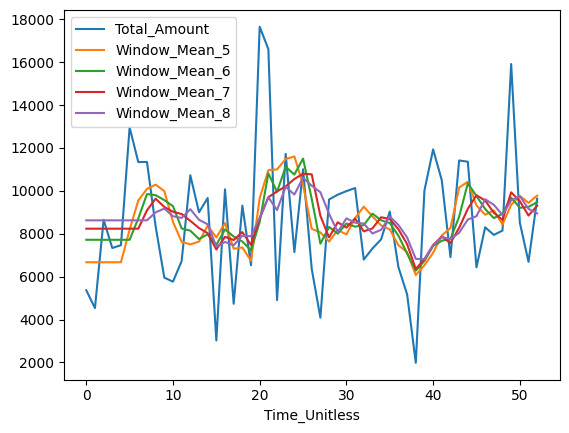

In [15]:
product_dfs[0].plot(x="Time_Unitless", y=["Total_Amount", "Window_Mean_5", "Window_Mean_6", "Window_Mean_7", "Window_Mean_8"])

In [22]:
next(iter(product_dfs[0].groupby([pd.Grouper(key="Date", freq="W-Mon")])))[1]

,Date,Gender,Age,Product_Category,Product_ID,Quantity,Price_per_Unit,Total_Amount,Male,Female
504,2023-01-20,Male,24,Beauty,2.0,1,50,50,1,0


In [ ]:
agg_list = {
    #"Product_ID": lambda x: 2,
    "Age": "median",
    "Male": "sum",
    "Female": "sum",
    "Quantity": "sum",
    "Total_Amount": "sum"
}
product_dfs[0].groupby([pd.Grouper(key="Date", freq="W-Mon")]).agg(
    agg_list
).reset_index()

,Date,Product_ID,Age,Male,Female,Quantity,Total_Amount
0,2023-01-23,2,24.0,1,0,1,50
1,2023-01-30,2,51.0,2,1,5,250
2,2023-02-06,2,25.0,0,1,4,200
3,2023-02-13,2,59.5,2,0,6,300
4,2023-02-20,2,27.0,0,1,4,200
5,2023-02-27,2,46.5,2,0,5,250
6,2023-03-06,2,25.5,0,2,7,350
7,2023-03-13,2,NaN,0,0,0,0
8,2023-03-20,2,NaN,0,0,0,0
9,2023-03-27,2,39.0,3,0,8,400


# Proper way of aggregating data

In [9]:
agg_columns = {
    "Age": "mean",
    "Male": "sum", 
    "Female": "sum", 
    "Quantity_Beauty": "sum", 
    "Quantity_Clothing": "sum", 
    "Quantity_Electronics": "sum", 
    "Total_Amount_Beauty": "sum", 
    "Total_Amount_Clothing": "sum", 
    "Total_Amount_Electronics": "sum",
}

# Generate Week, Month and Year numerical columns
df_week_agg = df_net.groupby([pd.Grouper(key='Date', freq='W-Mon')]).agg(agg_columns).reset_index()
df_week_agg["Age"] = df_week_agg["Age"].astype(int)
df_week_agg["Year"] = df_week_agg["Date"].dt.year
df_week_agg["Month"] = df_week_agg["Date"].dt.month
df_week_agg["Week"] = df_week_agg["Date"].dt.isocalendar().week


# Generate LAG columns for Total Amount (Revenue) for each category
individual_lags = 4
for lag in range(2, individual_lags+1):
    df_week_agg[f"TAB_M{lag}"] = df_week_agg["Total_Amount_Beauty"].rolling(lag).mean().bfill().ffill().round(2)
    df_week_agg[f"TAC_M{lag}"] = df_week_agg["Total_Amount_Clothing"].rolling(lag).mean().bfill().ffill().round(2)
    df_week_agg[f"TAE_M{lag}"] = df_week_agg["Total_Amount_Electronics"].rolling(lag).mean().bfill().ffill().round(2)

#[main_columns].sum().reset_index()
df_week_agg

,Date,Age,Male,Female,Quantity_Beauty,Quantity_Clothing,Quantity_Electronics,Total_Amount_Beauty,Total_Amount_Clothing,Total_Amount_Electronics,...,Week,TAB_M2,TAC_M2,TAE_M2,TAB_M3,TAC_M3,TAE_M3,TAB_M4,TAC_M4,TAE_M4
0,2023-01-02,38,3,4,4.0,13.0,3.0,1525.0,3750.0,90.0,...,1,1632.5,2637.5,680.0,2355.00,2365.00,1463.33,1926.25,2586.25,1958.75
1,2023-01-09,44,8,6,9.0,13.0,11.0,1740.0,1525.0,1270.0,...,2,1632.5,2637.5,680.0,2355.00,2365.00,1463.33,1926.25,2586.25,1958.75
2,2023-01-16,37,8,10,23.0,9.0,19.0,3800.0,1820.0,3030.0,...,3,2770.0,1672.5,2150.0,2355.00,2365.00,1463.33,1926.25,2586.25,1958.75
3,2023-01-23,42,4,11,5.0,15.0,12.0,640.0,3250.0,3445.0,...,4,2220.0,2535.0,3237.5,2060.00,2198.33,2581.67,1926.25,2586.25,1958.75
4,2023-01-30,39,12,7,18.0,19.0,13.0,4725.0,1880.0,860.0,...,5,2682.5,2565.0,2152.5,3055.00,2316.67,2445.00,2726.25,2118.75,2151.25
5,2023-02-06,37,10,15,14.0,23.0,30.0,1705.0,5980.0,5270.0,...,6,3215.0,3930.0,3065.0,2356.67,3703.33,3191.67,2717.50,3232.50,3151.25
6,2023-02-13,43,13,9,21.0,15.0,19.0,5425.0,2500.0,3415.0,...,7,3565.0,4240.0,4342.5,3951.67,3453.33,3181.67,3123.75,3402.50,3247.50
7,2023-02-20,32,11,4,12.0,18.0,11.0,3400.0,3715.0,4230.0,...,8,4412.5,3107.5,3822.5,3510.00,4065.00,4305.00,3813.75,3518.75,3443.75
8,2023-02-27,39,14,8,17.0,19.0,13.0,3405.0,3185.0,1750.0,...,9,3402.5,3450.0,2990.0,4076.67,3133.33,3131.67,3483.75,3845.00,3666.25
9,2023-03-06,42,4,16,26.0,14.0,15.0,2830.0,475.0,2650.0,...,10,3117.5,1830.0,2200.0,3211.67,2458.33,2876.67,3765.00,2468.75,3011.25


In [ ]:
# The whole purpose of this cell is just to reorder the dataframe columns
# It is not necessary for training the model.
df_week_agg.columns
date_columns = [
    "Date",
    "Year",
    "Month",
    "Week"    .ffill()
]

target_columns = [
    "Total_Amount_Beauty", 
    "Total_Amount_Clothing",
    "Total_Amount_Electronics"
]

covariate_columns = []
for covariate in df_week_agg.columns:
    if covariate not in date_columns and covariate not in target_columns:
        covariate_columns.append(covariate)

new_columns_order = []
new_columns_order.extend([*date_columns, *covariate_columns, *target_columns])

In [34]:
df_week_agg = df_week_agg[new_columns_order]
df_week_agg

,Date,Year,Month,Week,Age,Male,Female,Quantity_Beauty,Quantity_Clothing,Quantity_Electronics,...,TAE_2,TAB_3,TAC_3,TAE_3,TAB_4,TAC_4,TAE_4,Total_Amount_Beauty,Total_Amount_Clothing,Total_Amount_Electronics
0,2023-01-02,2023,1,1,38,3,4,4.0,13.0,3.0,...,90.0,1525.0,3750.0,90.0,1525.0,3750.0,90.0,1525.0,3750.0,90.0
1,2023-01-09,2023,1,2,44,8,6,9.0,13.0,11.0,...,90.0,1525.0,3750.0,90.0,1525.0,3750.0,90.0,1740.0,1525.0,1270.0
2,2023-01-16,2023,1,3,37,8,10,23.0,9.0,19.0,...,90.0,1525.0,3750.0,90.0,1525.0,3750.0,90.0,3800.0,1820.0,3030.0
3,2023-01-23,2023,1,4,42,4,11,5.0,15.0,12.0,...,1270.0,1525.0,3750.0,90.0,1525.0,3750.0,90.0,640.0,3250.0,3445.0
4,2023-01-30,2023,1,5,39,12,7,18.0,19.0,13.0,...,3030.0,1740.0,1525.0,1270.0,1525.0,3750.0,90.0,4725.0,1880.0,860.0
5,2023-02-06,2023,2,6,37,10,15,14.0,23.0,30.0,...,3445.0,3800.0,1820.0,3030.0,1740.0,1525.0,1270.0,1705.0,5980.0,5270.0
6,2023-02-13,2023,2,7,43,13,9,21.0,15.0,19.0,...,860.0,640.0,3250.0,3445.0,3800.0,1820.0,3030.0,5425.0,2500.0,3415.0
7,2023-02-20,2023,2,8,32,11,4,12.0,18.0,11.0,...,5270.0,4725.0,1880.0,860.0,640.0,3250.0,3445.0,3400.0,3715.0,4230.0
8,2023-02-27,2023,2,9,39,14,8,17.0,19.0,13.0,...,3415.0,1705.0,5980.0,5270.0,4725.0,1880.0,860.0,3405.0,3185.0,1750.0
9,2023-03-06,2023,3,10,42,4,16,26.0,14.0,15.0,...,4230.0,5425.0,2500.0,3415.0,1705.0,5980.0,5270.0,2830.0,475.0,2650.0


<Axes: xlabel='Date'>

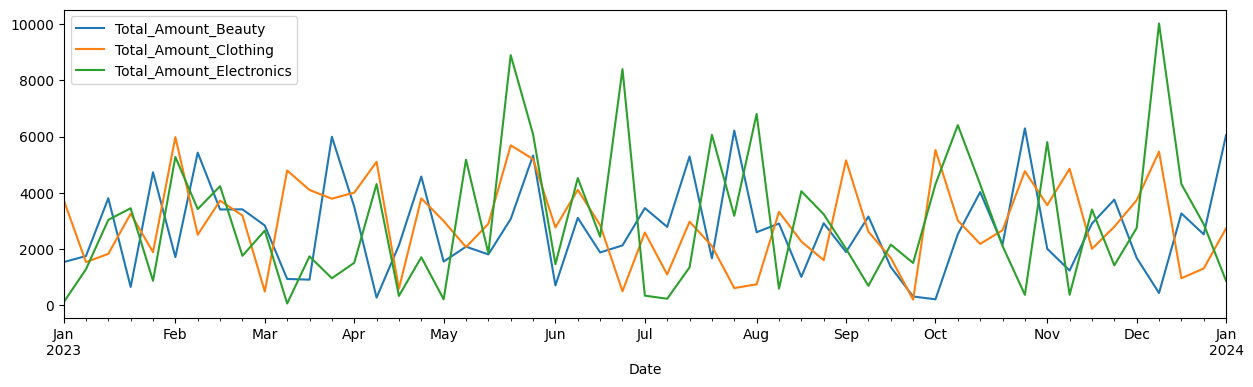

In [50]:
df_week_agg.plot(x="Date", y=["Total_Amount_Beauty", "Total_Amount_Clothing", "Total_Amount_Electronics"], figsize=(15,4))

# Test Model Training

In [57]:
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.datasets import ElectricityConsumptionZurichDataset
from darts import concatenate

In [40]:
df_week_agg.iloc[:,:-3]

,Date,Year,Month,Week,Age,Male,Female,Quantity_Beauty,Quantity_Clothing,Quantity_Electronics,...,TAE_1,TAB_2,TAC_2,TAE_2,TAB_3,TAC_3,TAE_3,TAB_4,TAC_4,TAE_4
0,2023-01-02,2023,1,1,38,3,4,4.0,13.0,3.0,...,90.0,1525.0,3750.0,90.0,1525.0,3750.0,90.0,1525.0,3750.0,90.0
1,2023-01-09,2023,1,2,44,8,6,9.0,13.0,11.0,...,90.0,1525.0,3750.0,90.0,1525.0,3750.0,90.0,1525.0,3750.0,90.0
2,2023-01-16,2023,1,3,37,8,10,23.0,9.0,19.0,...,1270.0,1525.0,3750.0,90.0,1525.0,3750.0,90.0,1525.0,3750.0,90.0
3,2023-01-23,2023,1,4,42,4,11,5.0,15.0,12.0,...,3030.0,1740.0,1525.0,1270.0,1525.0,3750.0,90.0,1525.0,3750.0,90.0
4,2023-01-30,2023,1,5,39,12,7,18.0,19.0,13.0,...,3445.0,3800.0,1820.0,3030.0,1740.0,1525.0,1270.0,1525.0,3750.0,90.0
5,2023-02-06,2023,2,6,37,10,15,14.0,23.0,30.0,...,860.0,640.0,3250.0,3445.0,3800.0,1820.0,3030.0,1740.0,1525.0,1270.0
6,2023-02-13,2023,2,7,43,13,9,21.0,15.0,19.0,...,5270.0,4725.0,1880.0,860.0,640.0,3250.0,3445.0,3800.0,1820.0,3030.0
7,2023-02-20,2023,2,8,32,11,4,12.0,18.0,11.0,...,3415.0,1705.0,5980.0,5270.0,4725.0,1880.0,860.0,640.0,3250.0,3445.0
8,2023-02-27,2023,2,9,39,14,8,17.0,19.0,13.0,...,4230.0,5425.0,2500.0,3415.0,1705.0,5980.0,5270.0,4725.0,1880.0,860.0
9,2023-03-06,2023,3,10,42,4,16,26.0,14.0,15.0,...,1750.0,3400.0,3715.0,4230.0,5425.0,2500.0,3415.0,1705.0,5980.0,5270.0


In [99]:
num_tseries = 3

target1 = TimeSeries.from_dataframe(df_week_agg.iloc[:-8,[0, -3]], time_col="Date")
target2 = TimeSeries.from_dataframe(df_week_agg.iloc[:-8,[0, -2]], time_col="Date")
target3 = TimeSeries.from_dataframe(df_week_agg.iloc[:-8,[0, -1]], time_col="Date")

cov_series = TimeSeries.from_dataframe(df_week_agg.iloc[:-8,:-3], time_col="Date")

all_targets = [target1, target2, target3]
all_past_covs = [cov_series]*num_tseries

In [118]:
model = NBEATSModel(
    input_chunk_length=12,
    output_chunk_length=8,
    n_epochs=100
)

In [119]:
model.fit(
    all_targets,
    past_covariates=all_past_covs
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 8.1 M  | train
-------------------------------------------------------------
8.1 M     Trainable params
2.9 K     Non-trainable params
8.1 M     Total params
32.451    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 24.01it/s, train_loss=153.0]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 23.76it/s, train_loss=153.0]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=12, output_chunk_length=8, n_epochs=100)

In [ ]:
model

In [125]:
pred = model.predict(
    n=8,
    series=all_targets[0],
    past_covariates=all_past_covs[0],
    num_samples=200
)

ValueError: `num_samples > 1` is only supported for probabilistic models.


ValueError: `num_samples > 1` is only supported for probabilistic models.

<Axes: xlabel='Date'>

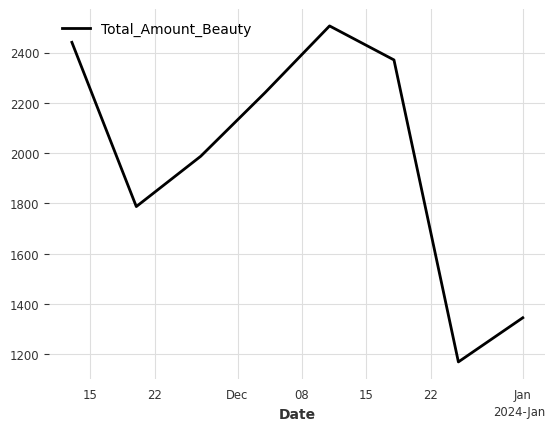

In [121]:
pred.plot()

<Axes: >

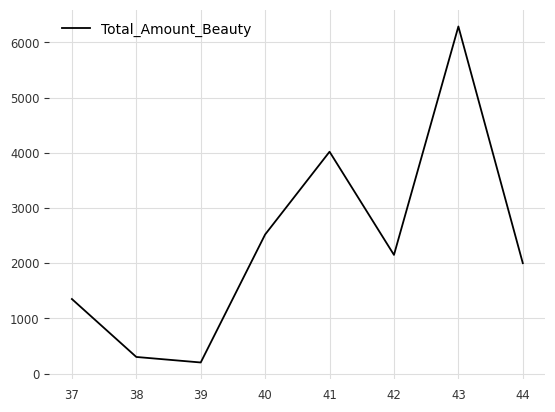

In [124]:
df_week_agg.iloc[-8*2:-8, [-3]].plot()

In [58]:
ts_energy = ElectricityConsumptionZurichDataset().load()

In [59]:
ts_energy

<TimeSeries (DataArray) (Timestamp: 268705, component: 10, sample: 1)> Size: 21MB
array([[[2.19759378e+04],
        [4.40624184e+04],
        [9.04700000e+01],
        ...,
        [6.10000000e-01],
        [6.00000000e-01],
        [9.82640000e+02]],

       [[2.21979830e+04],
        [4.34623818e+04],
        [9.02200000e+01],
        ...,
        [7.80000000e-01],
        [7.80000000e-01],
        [9.82730000e+02]],

       [[2.24494484e+04],
        [4.30025206e+04],
        [8.99600000e+01],
        ...,
...
        ...,
        [1.29000000e+00],
        [7.30000000e-01],
        [9.67830000e+02]],

       [[2.16048255e+04],
        [3.35396899e+04],
        [8.13400000e+01],
        ...,
        [1.11000000e+00],
        [5.30000000e-01],
        [9.67820000e+02]],

       [[2.13621552e+04],
        [3.26288579e+04],
        [8.16400000e+01],
        ...,
        [9.30000000e-01],
        [3.30000000e-01],
        [9.67800000e+02]]])
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 2MB 2015-01-01 ... 2022-08-31
  * component  (component) <U13 520B 'Value_NE5' 'Value_NE7' ... 'p [hPa]'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

# Category Level Aggregation

In [ ]:
df_categ_agg = df_net.groupby(["Product_Category", pd.Grouper(key='Date', freq='W-MON')])[["Male", "Female", "Quantity", "Total_Amount"]].sum().reset_index()
df_categ_agg

,Product Category,Date,Male,Female,Quantity,Total Amount
0,Beauty,2023-01-02,1,1,4,1525
1,Beauty,2023-01-09,3,1,9,1740
2,Beauty,2023-01-16,2,6,23,3800
3,Beauty,2023-01-23,1,3,5,640
4,Beauty,2023-01-30,2,5,18,4725
...,...,...,...,...,...,...
154,Electronics,2023-12-04,4,4,18,2740
155,Electronics,2023-12-11,6,7,33,10025
156,Electronics,2023-12-18,4,6,21,4305
157,Electronics,2023-12-25,2,6,19,2875


In [18]:
df_categ_agg["Product Category"].unique()

array(['Beauty', 'Clothing', 'Electronics'], dtype=object)

In [19]:
df_categ_agg_b = df_categ_agg[df_categ_agg["Product Category"] == "Beauty"]
df_categ_agg_c = df_categ_agg[df_categ_agg["Product Category"] == "Clothing"]
df_categ_agg_e = df_categ_agg[df_categ_agg["Product Category"] == "Electronics"]

In [ ]:
df_categ_agg_b.merge(df_categ_agg_c, how="outer", on="Date", suffixes=["_b", "_c"])

,Product Category_b,Date,Male_b,Female_b,Quantity_b,Total Amount_b,Product Category_c,Male_c,Female_c,Quantity_c,Total Amount_c
0,Beauty,2023-01-02,1,1,4,1525,Clothing,1,3,13,3750
1,Beauty,2023-01-09,3,1,9,1740,Clothing,4,1,13,1525
2,Beauty,2023-01-16,2,6,23,3800,Clothing,1,3,9,1820
3,Beauty,2023-01-23,1,3,5,640,Clothing,2,4,15,3250
4,Beauty,2023-01-30,2,5,18,4725,Clothing,6,0,19,1880
5,Beauty,2023-02-06,2,5,14,1705,Clothing,5,4,23,5980
6,Beauty,2023-02-13,6,1,21,5425,Clothing,4,3,15,2500
7,Beauty,2023-02-20,2,1,12,3400,Clothing,5,2,18,3715
8,Beauty,2023-02-27,4,4,17,3405,Clothing,7,2,19,3185
9,Beauty,2023-03-06,2,8,26,2830,Clothing,1,4,14,475


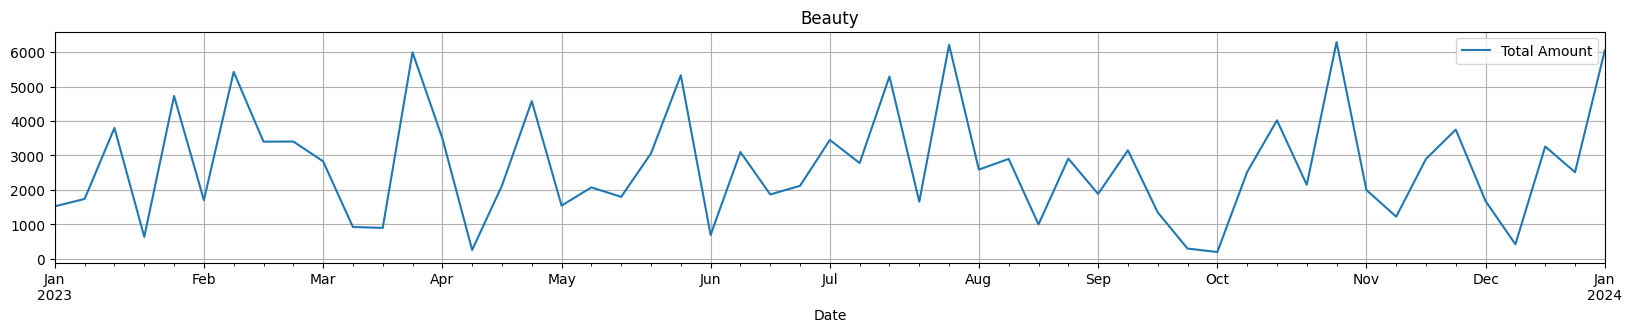

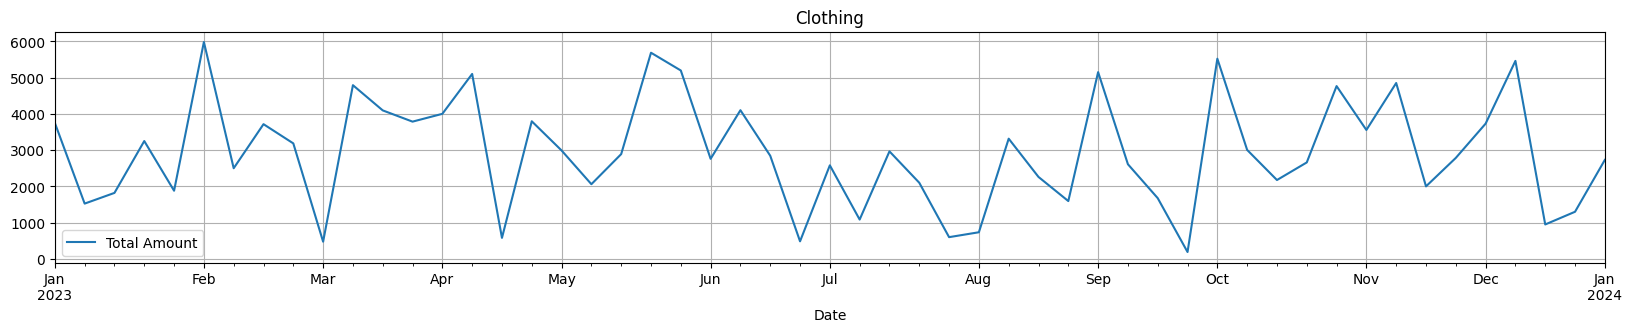

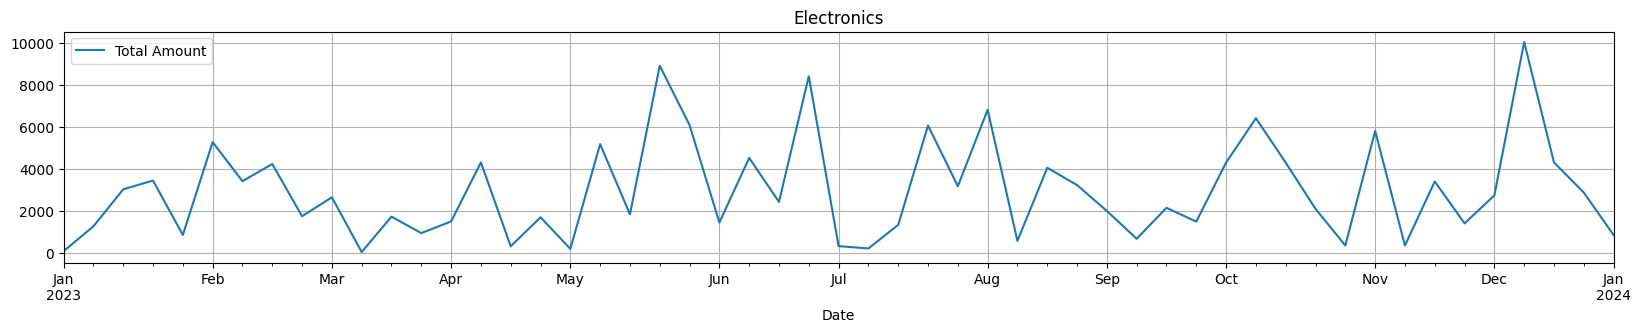

In [9]:
for category in df_categ_agg["Product Category"].unique():
    df_categ_agg[df_categ_agg["Product Category"] == category].plot(x="Date", y="Total Amount", figsize=(20,3), title=category, grid=True)

# Product Level Aggregation

In [10]:
df_week_agg = df_net.groupby(["ProductID", pd.Grouper(key='Date', freq='W-MON')])["Total Amount"].sum().reset_index().sort_values(by=["ProductID", "Date"])
df_week_agg.head()

,ProductID,Date,Total Amount
0,0.0,2023-01-02,25
1,0.0,2023-01-09,50
2,0.0,2023-01-16,250
3,0.0,2023-01-30,75
4,0.0,2023-02-06,25


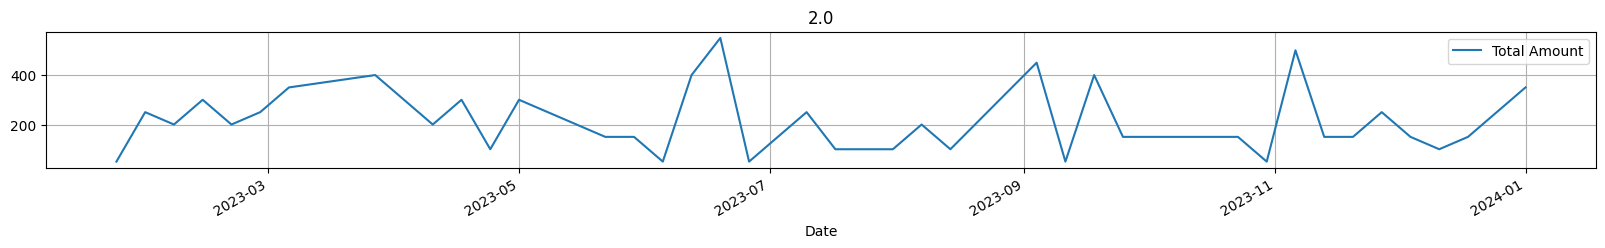

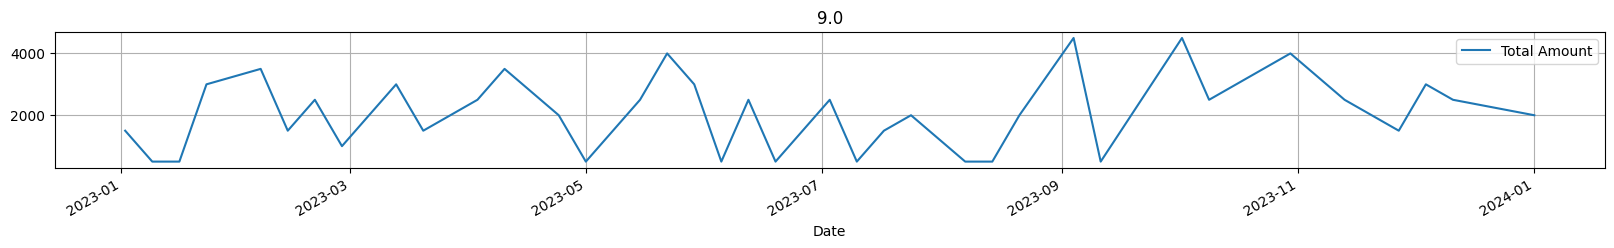

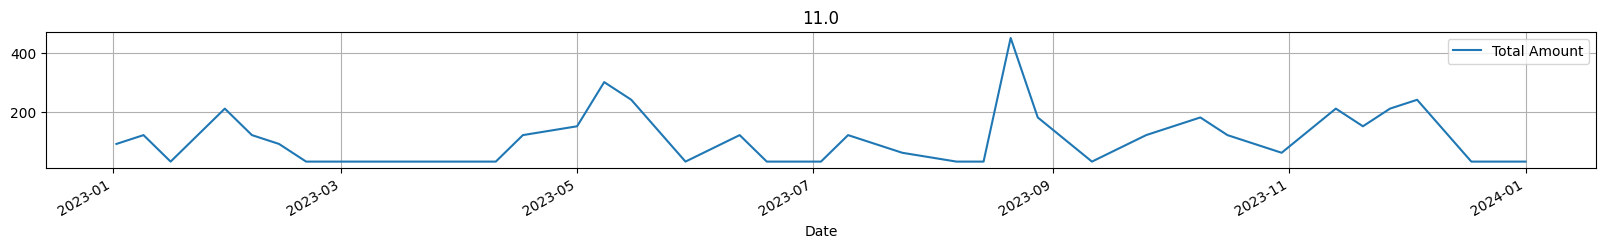

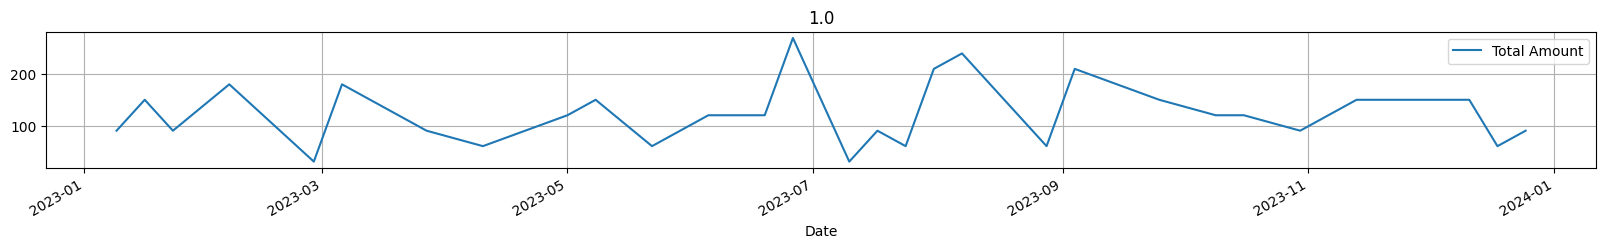

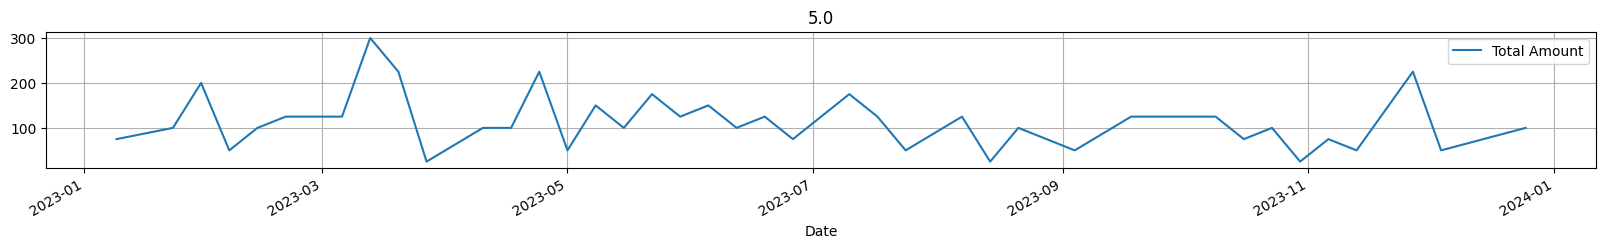

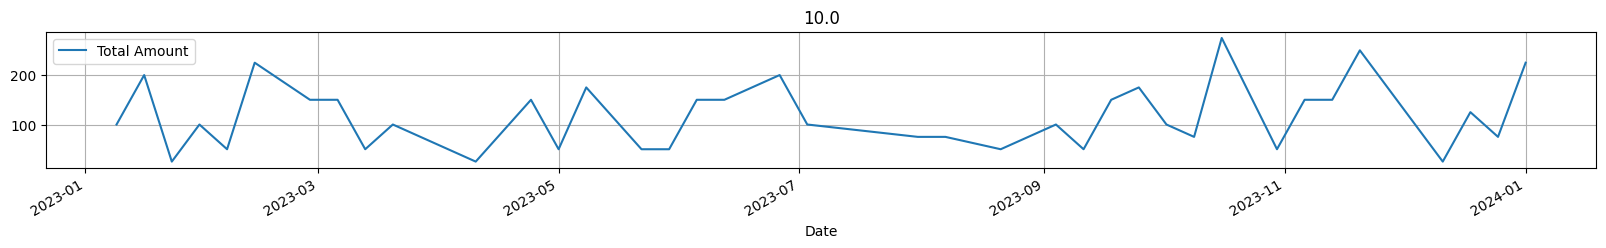

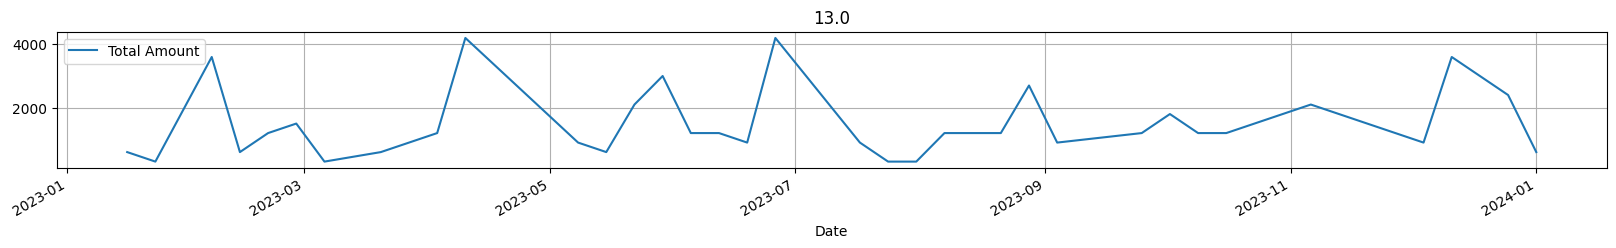

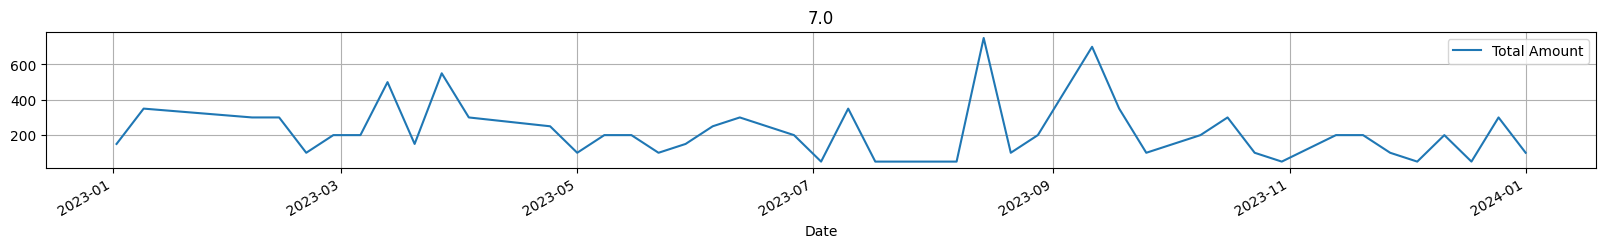

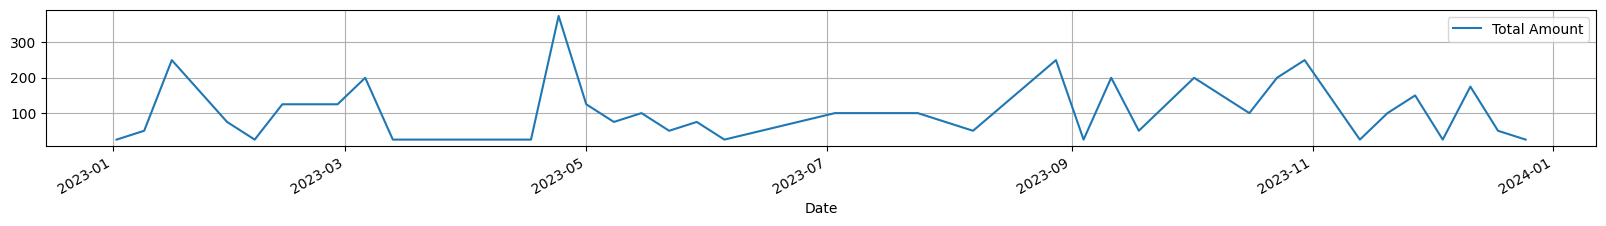

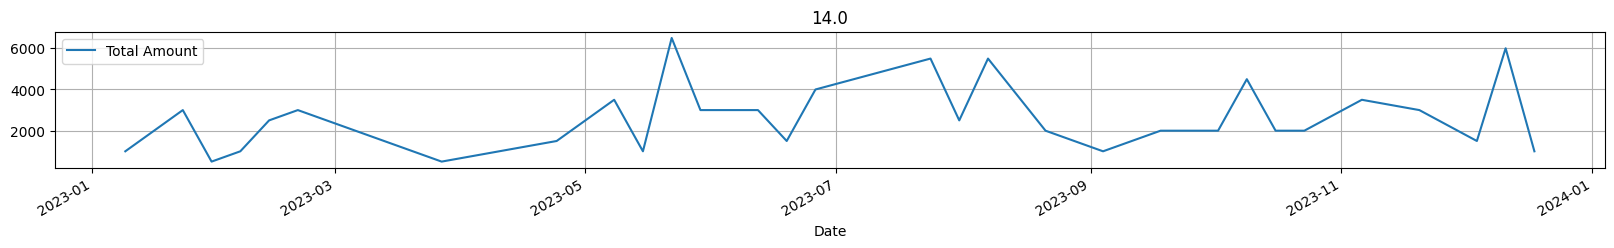

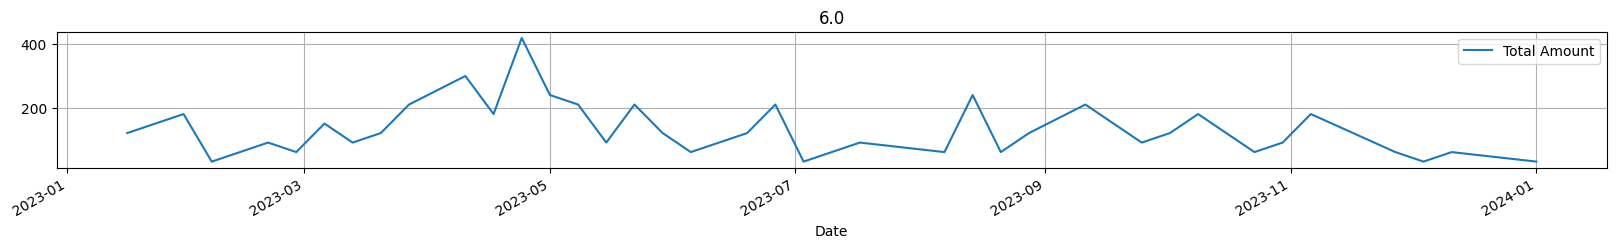

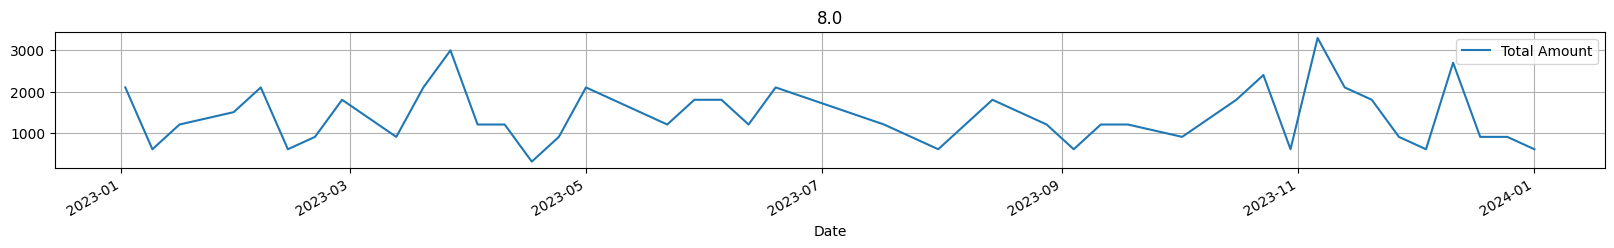

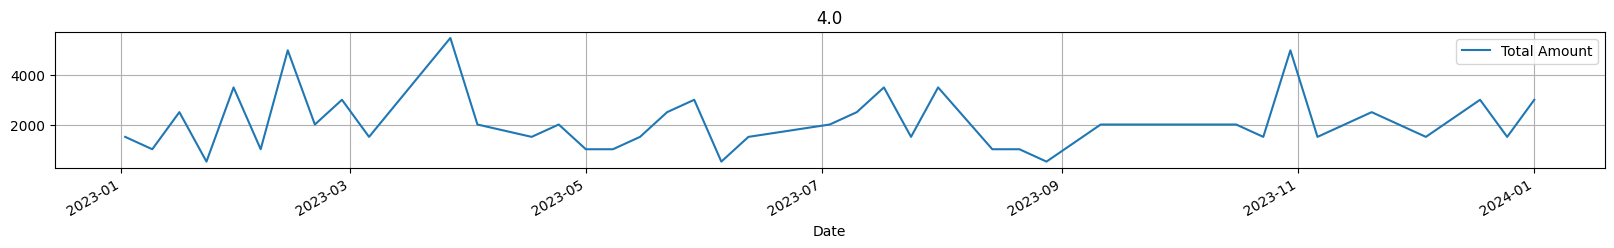

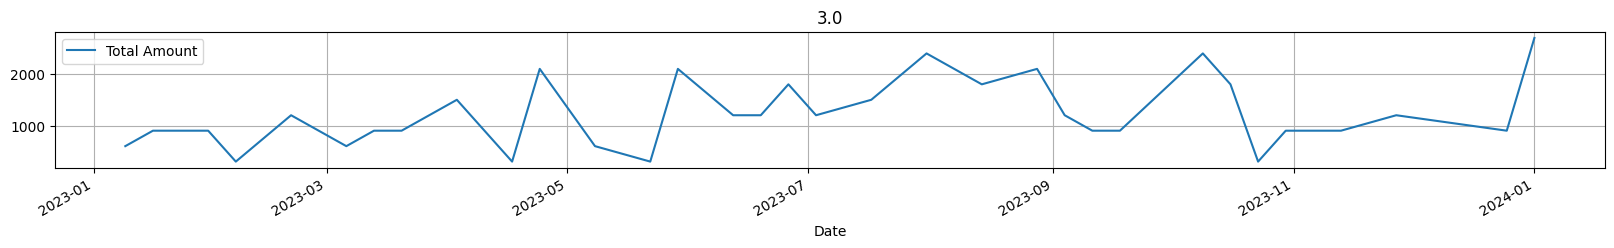

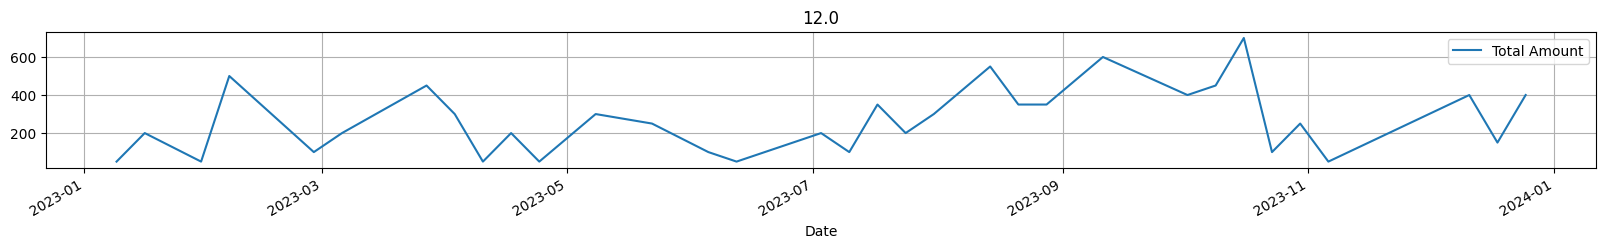

In [11]:
for id in df_net["ProductID"].unique():
    df_week_agg[df_week_agg["ProductID"] == id].plot(x="Date", y="Total Amount", grid=True, figsize=(20,2), title=id)

In [ ]:
# Assumptions:
#   Each unique price for each category represents a unique product.
#   -We have created IDs for each product based on the combination of CATEGORY and PRICE
#   -We could assume the interest relies on predicting future TOTAL/OVERALL 
#    sales for EACH category.

# We will define FUTURE sales weekly as for real life implementations
# a daily level of aggregation is not realisticly and doesn't provide 
# much value, instead a granularity level Weekly is more reasonable to
# handle and give a better business insight on performance allowing 
# opportunity for the departments to take advantage increasing the chain value.

#   -We can make a model that predicts the sales for EACH category
#   -We can make a model that predicts the sale for EACH category and 
# Some feature Engineering that can be done:
#   -Decompose Date column in Year, Month, Day
#   -Age can be aggregated in Bins
#   -Gender can be relabeled as One-hot encoded
#    